In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-29 13:07:00 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-29 13:07:00 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-29 13:07:00 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-29 13:07:05 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-29 13:07:05 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-29 13:07:05 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-29 13:07:05 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-29 13:07:06 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-29 13:07:06 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-10-29 13:07:08 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-29 13:07:09 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-29 13:07:09 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-29 13:07:53 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-29 13:07:53 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-29 13:07:53 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)
select_task.filter_single_token(mt.tokenizer, prefix=" ")
print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(11), vehicle(8), furniture(8), animal(13), music instrument(3), clothing(11), electronics(10), sport equipment(5), kitchen appliance(4), vegetable(5), building(14), office supply(8), bathroom item(7), flower(6), tree(10), jewelry(7)



In [17]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

fruit >> ['Plum', 'Peach', 'Orange', 'Pear', 'Raspberry', 'Banana', 'Apple', 'Mango', 'Cherry', 'Grape', 'Strawberry']
Plum -> Strawberry (2): ['Chair', 'Chain', 'Strawberry', 'Helmet', 'Router', 'Blender']
Options: Chair, Chain, Strawberry, Helmet, Router, Blender.
Which among these objects mentioned above is a fruit?
Answer:


In [18]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Chair, Chain, Strawberry, Helmet, Router, Blender.
Which among these objects mentioned above is a fruit?
Answer:" >> Strawberry


(True,
 [PredictedToken(token=' Strawberry', prob=0.6875, logit=21.5, token_id=89077, metadata=None),
  PredictedToken(token=' The', prob=0.1533203125, logit=20.0, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.08203125, logit=19.375, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.038818359375, logit=18.625, token_id=362, metadata=None),
  PredictedToken(token=' strawberry', prob=0.004608154296875, logit=16.5, token_id=73700, metadata=None)],
 OrderedDict([(89077,
               (1,
                PredictedToken(token=' Strawberry', prob=0.6875, logit=21.5, token_id=89077, metadata=None))),
              (16478,
               (102,
                PredictedToken(token=' Chair', prob=2.276897430419922e-05, logit=11.1875, token_id=16478, metadata=None))),
              (29625,
               (150,
                PredictedToken(token=' Chain', prob=1.1444091796875e-05, logit=10.5, token_id=29625, metadata=None))),
              (88668,
      

In [9]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Apple.
Explanation: Apple is a fruit. The other options are not fruits. Marker is a writing" >> Apple


In [10]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [11]:
llama_70_heads = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

qwen_72_heads = [
    (62, 1),
    (60, 9),
    (64, 8),
    (62, 0),
    (62, 45),
    (59, 59),
    (71, 28),
    (64, 12),
    (61, 7),
    (64, 13),
    (67, 53),
    (67, 51),
    (54, 44),
    (57, 5),
    (59, 60),
    (71, 25),
    (62, 7),
    (64, 9),
    (62, 23),
    (65, 40),
]

qwen_32_heads = [
    (51, 11),
    (48, 4),
    (52, 21),
    (54, 35),
    (48, 8),
    (50, 6),
    (48, 9),
    (48, 32),
    (52, 10),
    (45, 11),
    (45, 13),
    (48, 34),
    (53, 16),
    (50, 12),
    (49, 2),
    (54, 38),
    (55, 4),
    (50, 27),
    (54, 33),
    (50, 14),
]


# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]

# HEADS = qwen_32_heads
HEADS = llama_70_heads
print(len(HEADS))

10


2025-10-29 13:08:46 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-10-29 13:08:46 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-10-29 13:08:46 matplotlib DEBUG    interactive is False
2025-10-29 13:08:46 matplotlib DEBUG    platform is linux
2025-10-29 13:08:47 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-10-29 13:08:47 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-10-29 13:08:47 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-29 13:08:47 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-29 13:08:47 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-10-29 13:08:47 matplotlib.font

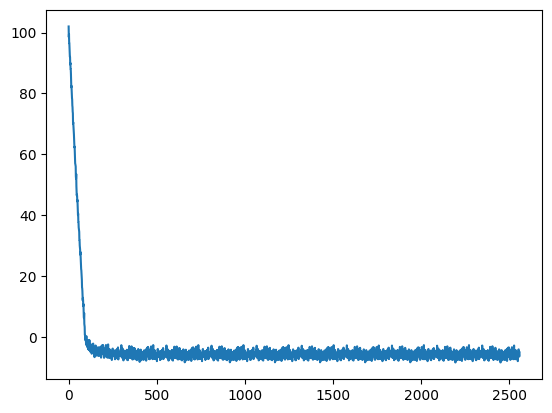

In [12]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    # mt.name.split("/")[-1],
    model_key.split("/")[-1],
    "distinct_options",
    f"{select_task.task_name}",
    "epoch_10.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

78


(True, True)

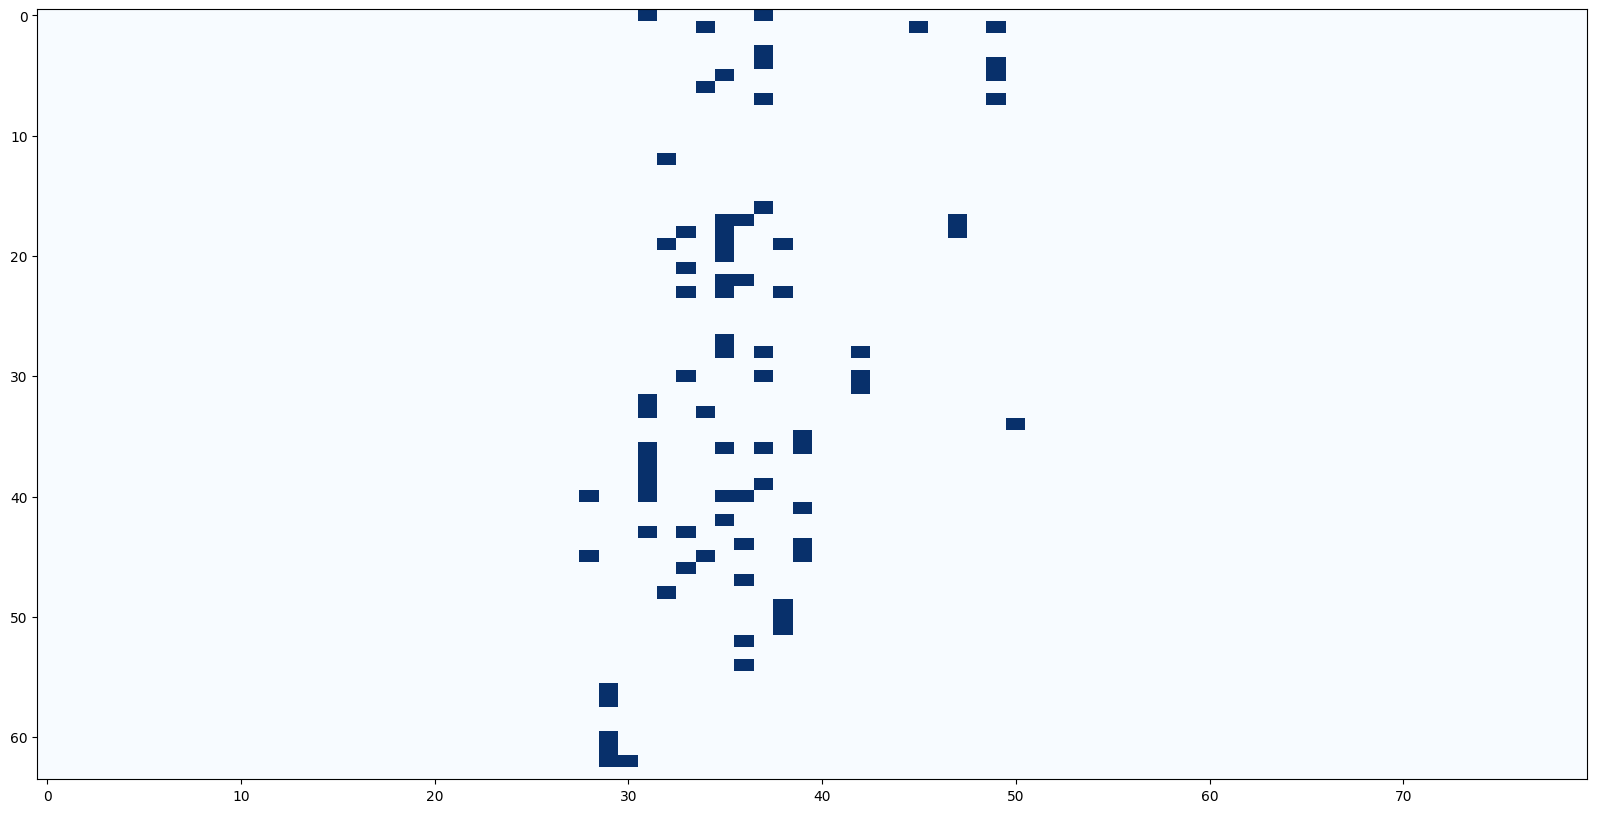

In [14]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [19]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS,
)

2025-10-29 13:09:37 src.selection.functional DEBUG    Predictions: ['" Strawberry"[89077] (p=0.688, logit=21.500)', '" The"[578] (p=0.153, logit=20.000)', '" Among"[22395] (p=0.082, logit=19.375)', '" A"[362] (p=0.039, logit=18.625)', '" strawberry"[73700] (p=0.005, logit=16.500)']
2025-10-29 13:09:37 src.selection.functional INFO     Combined attention matrix for all heads


In [20]:
from src.selection.data import get_counterfactual_samples_within_task

patch_sample, clean_sample = get_counterfactual_samples_within_task(
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    n_distractors = N_DISTRACTORS,
)

clean_sample.metadata

2025-10-29 13:09:40 src.selection.data INFO     clean_obj_idx=0 | ['Boat', 'Dolphin', 'Necklace', 'Pear', 'Mirror', 'Laptop']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-29 13:09:40 src.selection.data INFO     Options: Comb, Mango, Phone, Van, Gloves, Ottoman.
Which among these objects mentioned above is a fruit?
Answer:
2025-10-29 13:09:40 src.selection.data INFO     Grape | fruit -> Mango | pred=['" Mango"[91963] (p=0.867, logit=22.250)', '" The"[578] (p=0.062, logit=19.625)', '" Among"[22395] (p=0.038, logit=19.125)', '" A"[362] (p=0.008, logit=17.625)', '" ("[320] (p=0.002, logit=16.375)']
2025-10-29 13:09:40 src.selection.data INFO     Options: Boat, Dolphin, Necklace, Pear, Mirror, Laptop.
Which among these objects mentioned above is a vehicle?
Answer:
2025-10-29 13:09:40 src.selection.data INFO     Bike | vehicle -> Boat | pred=['" Boat"[45332] (p=0.820, logit=22.125)', '" The"[578] (p=0.059, logit=19.500)', '" A"[362] (p=0.059, logit=19.500)', '" Among"[22395] (p=0.022, logit=18.500)', '" It"[1102] (p=0.004, logit=16.875)']
2025-10-29 13:09:40 src.selection.data INFO     Options: Boa

{'track_category': 'fruit',
 'track_type_obj': 'Pear',
 'track_type_obj_idx': 3,
 'track_type_obj_token_id': 23910,
 'ques_pos': 24,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  45332,     11,  96096,     11,  86460,     11,
            23910,     11,  34954,     11,  57225,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

In [21]:
patch_sample.metadata, clean_sample.metadata

({'track_category': 'vehicle',
  'track_type_obj': 'Van',
  'track_type_obj_idx': 3,
  'track_type_obj_token_id': 13000,
  'ques_pos': 24,
  'tokenized': {'input_ids': tensor([[128000,   3883,     25,  23262,     11,  91963,     11,  14642,     11,
             13000,     11,  68554,     11,  70110,    627,  23956,   4315,   1521,
              6302,   9932,   3485,    374,    264,  14098,   5380,  16533,     25]],
          device='cuda:0'),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1]], device='cuda:0')}},
 {'track_category': 'fruit',
  'track_type_obj': 'Pear',
  'track_type_obj_idx': 3,
  'track_type_obj_token_id': 23910,
  'ques_pos': 24,
  'tokenized': {'input_ids': tensor([[128000,   3883,     25,  45332,     11,  96096,     11,  86460,     11,
             23910,     11,  34954,     11,  57225,    627,  23956,   4315,   1521,
              6302,   9932,   3485,    374,    264,   7458,   5380,  16533, 

In [22]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )
len(HEADS)

78

In [23]:
from src.functional import generate_with_patch

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj

for sample in [patch_sample, clean_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-1
    )

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Comb, Mango, Phone, Van, Gloves, Ottoman.
Which among these objects mentioned above is a fruit?
Answer: >> Mango
2025-10-29 13:09:48 src.selection.functional DEBUG    Generated full answer: " Mango. Mango is a fruit. The rest of the options are objects or things. A comb is used for hair, a phone is a device for"
2025-10-29 13:09:48 src.selection.functional DEBUG    Predictions: ['" Mango"[91963] (p=0.867, logit=22.250)', '" The"[578] (p=0.062, logit=19.625)', '" Among"[22395] (p=0.038, logit=19.125)', '" A"[362] (p=0.008, logit=17.625)', '" M"[386] (p=0.002, logit=16.375)']
2025-10-29 13:09:48 src.selection.functional INFO     Combined attention matrix for all heads


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Options: Boat, Dolphin, Necklace, Pear, Mirror, Laptop.
Which among these objects mentioned above is a vehicle?
Answer: >> Boat
2025-10-29 13:09:52 src.selection.functional DEBUG    Generated full answer: " Boat.
Explanation: A boat is a type of vehicle that is used for transportation on water. The other options are not vehicles. A dolphin is a"
2025-10-29 13:09:52 src.selection.functional DEBUG    Predictions: ['" Boat"[45332] (p=0.820, logit=22.125)', '" A"[362] (p=0.059, logit=19.500)', '" The"[578] (p=0.059, logit=19.500)', '" Among"[22395] (p=0.022, logit=18.500)', '" It"[1102] (p=0.004, logit=16.875)']
2025-10-29 13:09:52 src.selection.functional INFO     Combined attention matrix for all heads


In [24]:
clean_sample.metadata

{'track_category': 'fruit',
 'track_type_obj': 'Pear',
 'track_type_obj_idx': 3,
 'track_type_obj_token_id': 23910,
 'ques_pos': 24,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  45332,     11,  96096,     11,  86460,     11,
            23910,     11,  34954,     11,  57225,    627,  23956,   4315,   1521,
             6302,   9932,   3485,    374,    264,   7458,   5380,  16533,     25]],
         device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]], device='cuda:0')}}

## Validation of the patching effect

In [26]:
from src.selection.data import CounterFactualSamplePair
import random

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks",
    # "rhymes",
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    # patch_category = cf_pair.patch_sample.category
    # random_category = random.choice(list(set(select_task.categories) - {patch_category}))
    # random_obj = random.choice(select_task.category_wise_examples[random_category])
    # cf_pair.patch_sample.options[cf_pair.patch_sample.obj_idx] = random_obj

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-10-29 13:11:04 __main__ INFO     Found 1024 sample files


512

In [27]:
clean, patch = validation_set[3]
print(patch.prompt(), ">>", mt.tokenizer.decode(patch.ans_token_id))
print(clean.prompt(), ">>", mt.tokenizer.decode(clean.ans_token_id))
clean.metadata["track_type_obj_token_id"], mt.tokenizer.decode(clean.metadata["track_type_obj_token_id"])

Options: Skateboard, Paper, Toothpaste.
Which among these objects mentioned above is a sport equipment?
Answer: >>  Skate
Options: Stapler, Baseball, Lotion.
Which among these objects mentioned above is a bathroom item?
Answer: >>  L


(38258, ' Baseball')

In [28]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair
import copy

clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)
# clean, patch = copy.deepcopy(validation_set[18])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"

# failed_case = failed_cases[17]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads = heads_selected,
    # heads = overlapping_heads,
    # heads=[(35, 19)],
    query_indices={-3: -3, -2: -2, -1: -1},
    verify_head_behavior_on=-1,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=2.0
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = after_intervention["target_rank"] - before_intervention["target_rank"]
logger.info(f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} ")
logger.info(f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} ")

clean_logit_delta = after_intervention["clean_logit"] - before_intervention["clean_logit"]
target_logit_delta =  after_intervention["target_logit"] - before_intervention["target_logit"]
logger.info(f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} ")
logger.info(f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} ")

Options: Boat, Dolphin, Necklace, Pear, Mirror, Laptop.
Which among these objects mentioned above is a vehicle?
Answer: >> Boat
Options: Comb, Mango, Phone, Van, Gloves, Ottoman.
Which among these objects mentioned above is a fruit?
Answer: >> Mango
2025-10-29 13:11:11 src.selection.optimization INFO     Verifying head behavior...
2025-10-29 13:11:11 src.selection.optimization INFO     Clean Sample >> Ans:  Boat


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-10-29 13:11:15 src.selection.functional DEBUG    Generated full answer: " Boat.
Explanation: A boat is a type of vehicle that is used for transportation on water. The other options are not vehicles. A dolphin is a"
2025-10-29 13:11:15 src.selection.functional DEBUG    Predictions: ['" Boat"[45332] (p=0.820, logit=22.125)', '" A"[362] (p=0.059, logit=19.500)', '" The"[578] (p=0.059, logit=19.500)', '" Among"[22395] (p=0.022, logit=18.500)', '" It"[1102] (p=0.004, logit=16.875)']
2025-10-29 13:11:15 src.selection.functional INFO     Combined attention matrix for all heads


2025-10-29 13:11:15 src.selection.optimization INFO     Patch Sample >> Ans:  Mango


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-10-29 13:11:19 src.selection.functional DEBUG    Generated full answer: " Mango. Mango is a fruit. The rest of the options are objects or things. A comb is used for hair, a phone is a device for"
2025-10-29 13:11:19 src.selection.functional DEBUG    Predictions: ['" Mango"[91963] (p=0.867, logit=22.250)', '" The"[578] (p=0.062, logit=19.625)', '" Among"[22395] (p=0.038, logit=19.125)', '" A"[362] (p=0.008, logit=17.625)', '" M"[386] (p=0.002, logit=16.375)']
2025-10-29 13:11:19 src.selection.functional INFO     Combined attention matrix for all heads


2025-10-29 13:11:19 src.selection.optimization INFO     Caching the query states for the 78 heads
2025-10-29 13:11:19 src.selection.optimization INFO     patch_prediction=['" Mango"[91963] (p=0.867, logit=22.250)', '" The"[578] (p=0.062, logit=19.625)', '" Among"[22395] (p=0.038, logit=19.125)', '" A"[362] (p=0.008, logit=17.625)', '" ("[320] (p=0.002, logit=16.375)']
2025-10-29 13:11:19 src.selection.optimization INFO     clean run
2025-10-29 13:11:20 src.selection.optimization INFO     clean_prediction=['" Boat"[45332] (p=0.820, logit=22.125)', '" The"[578] (p=0.059, logit=19.500)', '" A"[362] (p=0.059, logit=19.500)', '" Among"[22395] (p=0.022, logit=18.500)', '" It"[1102] (p=0.004, logit=16.875)']
2025-10-29 13:11:20 src.selection.optimization INFO     clean_track=OrderedDict([(45332, (1, PredictedToken(token=' Boat', prob=0.8203125, logit=22.125, token_id=45332, metadata=None))), (57225, (23, PredictedToken(token=' Laptop', prob=0.000545501708984375, logit=14.8125, token_id=57225,

2025-10-29 13:11:20 src.selection.optimization INFO     int_prediction=['" Pear"[23910] (p=0.781, logit=21.250)', '" The"[578] (p=0.050, logit=18.500)', '" A"[362] (p=0.039, logit=18.250)', '" Among"[22395] (p=0.030, logit=18.000)', '" Boat"[45332] (p=0.024, logit=17.750)']
2025-10-29 13:11:20 src.selection.optimization INFO     int_track=OrderedDict([(23910, (1, PredictedToken(token=' Pear', prob=0.78125, logit=21.25, token_id=23910, metadata=None))), (45332, (5, PredictedToken(token=' Boat', prob=0.0235595703125, logit=17.75, token_id=45332, metadata=None))), (96096, (86, PredictedToken(token=' Dolphin', prob=5.4836273193359375e-05, logit=11.6875, token_id=96096, metadata=None))), (86460, (213, PredictedToken(token=' Necklace', prob=9.5367431640625e-06, logit=9.9375, token_id=86460, metadata=None))), (34954, (256, PredictedToken(token=' Mirror', prob=6.973743438720703e-06, logit=9.625, token_id=34954, metadata=None))), (57225, (525, PredictedToken(token=' Laptop', prob=1.996755599975

In [29]:
from src.utils.typing import TokenizerOutput
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
import baukit
import types
from src.tokens import prepare_input
from src.functional import interpret_logits
from src.selection.utils import get_first_token_id
import random


def ablate_attn_heads(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    heads: list[tuple[int, int]],
    block_edges: list[AttentionEdge],
):
    default_attn_implementation = mt.config._attn_implementation
    mt.reset_forward()
    mt.set_attn_implementation("sdpa")

    layers_to_heads = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)

    for layer_idx in sorted(list(layers_to_heads.keys())):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges={
                    head_idx: block_edges for head_idx in layers_to_heads[layer_idx]
                },
            ),
            attn_block,
        )

    with mt.trace(input) as tr:
        logits = mt.output.logits[:, -1, :].save()

    mt.reset_forward()
    mt.set_attn_implementation(default_attn_implementation)

    return logits


def get_edges_to_block(
    input: TokenizerOutput,
    whitelist_key_indices: list[int] = [0],
    query_indices: list[int] = [-1],
):
    block_edges: list[AttentionEdge] = []
    for idx in range(len(whitelist_key_indices)):
        if whitelist_key_indices[idx] < 0:
            whitelist_key_indices[idx] = (
                input.input_ids.shape[1] + whitelist_key_indices[idx]
            )
    for idx in range(len(query_indices)):
        if query_indices[idx] < 0:
            query_indices[idx] = input.input_ids.shape[1] + query_indices[idx]

    for key_idx in range(1, input.input_ids.shape[1]):
        if key_idx in whitelist_key_indices:
            continue
        for query_idx in query_indices:
            if query_idx < key_idx:
                continue  # autoregressive LM
            block_edges.append(AttentionEdge(q_idx=query_idx, k_idx=key_idx))
    return block_edges


mt.reset_forward()
mt.set_attn_implementation("eager")

answer_token = get_first_token_id(
    name=clean_sample.obj, tokenizer=mt.tokenizer, prefix=" "
)

# clean_run
clean_tokenized = prepare_input(tokenizer=mt.tokenizer, prompts=clean_sample.prompt())
print(clean_tokenized.input_ids.shape)
clean_logits = ablate_attn_heads(mt=mt, input=clean_tokenized, heads=[], block_edges=[])
clean_pred, clean_track = interpret_logits(
    tokenizer=mt.tokenizer,
    logits=clean_logits,
    interested_tokens=[answer_token],
)
logger.info(f"clean_pred={[str(pred) for pred in clean_pred]}")
logger.info(f"{clean_track=}")

# ablated_run
all_heads = [(layer, head) for layer in range(mt.config.num_hidden_layers) for head in range(mt.config.num_attention_heads)]
all_heads = list(set(all_heads) - set(HEADS))
random_heads = random.sample(all_heads, len(heads_selected))
ablated_logits = ablate_attn_heads(
    mt=mt,
    input=clean_tokenized,
    # heads=random_heads,
    heads=heads_selected,
    block_edges=get_edges_to_block(
        input=clean_tokenized, whitelist_key_indices=[0], query_indices=[-1]
    ),
)
ablated_pred, ablated_track = interpret_logits(
    tokenizer=mt.tokenizer,
    logits=ablated_logits,
    interested_tokens=[answer_token],
)

logger.info(f"ablated_pred={[str(pred) for pred in ablated_pred]}")
logger.info(f"{ablated_track=}")

torch.Size([1, 27])
2025-10-29 13:11:32 __main__ INFO     clean_pred=['" Boat"[45332] (p=0.824, logit=22.125)', '" The"[578] (p=0.060, logit=19.500)', '" A"[362] (p=0.052, logit=19.375)', '" Among"[22395] (p=0.025, logit=18.625)', '" It"[1102] (p=0.004, logit=16.875)']
2025-10-29 13:11:32 __main__ INFO     clean_track=OrderedDict([(45332, (1, PredictedToken(token=' Boat', prob=0.82421875, logit=22.125, token_id=45332, metadata=None)))])
2025-10-29 13:11:33 __main__ INFO     ablated_pred=['" Boat"[45332] (p=0.334, logit=18.625)', '" None"[2290] (p=0.295, logit=18.500)', '" Among"[22395] (p=0.066, logit=17.000)', '" The"[578] (p=0.066, logit=17.000)', '" A"[362] (p=0.040, logit=16.500)']
2025-10-29 13:11:33 __main__ INFO     ablated_track=OrderedDict([(45332, (1, PredictedToken(token=' Boat', prob=0.333984375, logit=18.625, token_id=45332, metadata=None)))])


In [30]:
clean_tokenized = prepare_input(tokenizer=mt.tokenizer, prompts=clean_sample.prompt())


block_edges = get_edges_to_block(
    input=clean_tokenized, whitelist_key_indices=[0], query_indices=[-1]
)

mt.reset_forward()
mt.set_attn_implementation("sdpa")

layers_to_heads = {}
for layer_idx, head_idx in [(35, 19)]:
    if layer_idx not in layers_to_heads:
        layers_to_heads[layer_idx] = []
    layers_to_heads[layer_idx].append(head_idx)

attn_matrices = {}
for layer_idx in sorted(list(layers_to_heads.keys())):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_matrices[layer_idx] = {}
    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            cut_attn_edges={
                head_idx: block_edges for head_idx in layers_to_heads[layer_idx]
            },
            save_attn_for=layers_to_heads[layer_idx],
            store_attn_matrices=attn_matrices[layer_idx]
        ),
        attn_block,
    )

with mt.trace(clean_tokenized) as tr:
    logits = mt.output.logits[:, -1, :].save()

mt.reset_forward()
mt.set_attn_implementation("eager")

interpret_logits(tokenizer=mt.tokenizer, logits=logits)

[PredictedToken(token=' Boat', prob=0.83984375, logit=22.375, token_id=45332, metadata=None),
 PredictedToken(token=' The', prob=0.0537109375, logit=19.625, token_id=578, metadata=None),
 PredictedToken(token=' A', prob=0.0537109375, logit=19.625, token_id=362, metadata=None),
 PredictedToken(token=' Among', prob=0.0174560546875, logit=18.5, token_id=22395, metadata=None),
 PredictedToken(token=' It', prob=0.0034332275390625, logit=16.875, token_id=1102, metadata=None)]

In [31]:
attn_matrices[35][19].shape

torch.Size([1, 27, 27])

In [32]:
from src.attention import visualize_attn_matrix

visualize_attn_matrix(
    attn_matrix=attn_matrices[35][19].squeeze(),
    tokens = [
        mt.tokenizer.decode(token_id) for token_id in clean_tokenized.input_ids[0]
    ],
    q_index = -1,
    start_from=0
)

In [42]:
function_vector_heads = [
    (18, 7),
    (22, 55),
    (30, 1),
    (30, 24),
    (31, 7),
    (31, 17),
    (31, 18),
    (31, 19),
    (31, 42),
    (32, 3),
    (32, 19),
    (32, 21),
    (33, 3),
    (33, 9),
    (33, 11),
    (33, 31),
    (33, 32),
    (33, 42),
    (33, 52),
    (34, 2),
    (34, 24),
    (34, 25),
    (34, 27),
    (34, 31),
    (34, 40),
    (34, 41),
    (34, 51),
    (34, 52),
    (34, 54),
    (35, 16),
    (35, 33),
    (35, 47),
    (35, 57),
    (36, 3),
    (36, 4),
    (36, 22),
    (37, 2),
    (37, 29),
    (38, 18),
    (38, 23),
    (38, 28),
    (38, 48),
    (38, 49),
    (38, 55),
    (38, 61),
    (38, 62),
    (39, 41),
    (39, 44),
    (40, 10),
    (40, 12),
    (40, 39),
    (41, 19),
    (41, 22),
    (44, 1),
    (44, 7),
    (45, 6),
    (48, 56),
    (49, 1),
    (54, 8),
    (55, 17),
    (55, 20),
    (66, 7),
    (67, 30),
    (69, 39),
    (69, 41),
    (70, 40),
    (72, 40),
    (73, 14),
    (73, 15),
    (73, 61),
    (74, 9),
    (75, 28),
    (76, 10),
    (76, 57),
    (76, 63),
    (77, 21),
    (77, 42),
    (78, 51),
    (79, 1),
]

In [43]:
concept_induction_heads = [
    [4, 55],
    [6, 33],
    [7, 16],
    [9, 9],
    [14, 0],
    [18, 2],
    [18, 7],
    [20, 50],
    [21, 36],
    [22, 51],
    [22, 55],
    [24, 50],
    [27, 17],
    [28, 41],
    [29, 48],
    [29, 58],
    [31, 21],
    [31, 47],
    [33, 5],
    [33, 42],
    [33, 48],
    [34, 24],
    [34, 25],
    [34, 30],
    [34, 50],
    [35, 19],
    [35, 33],
    [35, 43],
    [35, 45],
    [35, 46],
    [36, 6],
    [37, 5],
    [37, 6],
    [37, 9],
    [38, 48],
    [39, 40],
    [39, 61],
    [40, 12],
    [40, 39],
    [41, 19],
    [44, 1],
    [44, 4],
    [44, 7],
    [45, 6],
    [48, 56],
    [51, 4],
    [51, 60],
    [52, 17],
    [52, 21],
    [52, 27],
    [53, 3],
    [53, 4],
    [53, 32],
    [53, 35],
    [56, 3],
    [56, 15],
    [56, 20],
    [56, 41],
    [56, 45],
    [60, 19],
    [60, 20],
    [60, 25],
    [66, 7],
    [67, 60],
    [67, 61],
    [68, 48],
    [70, 4],
    [70, 40],
    [71, 42],
    [72, 45],
    [72, 46],
    [72, 62],
    [73, 15],
    [73, 38],
    [73, 53],
    [74, 41],
    [75, 53],
    [76, 10],
    [76, 57],
]

In [44]:
from tqdm.auto import tqdm

# ablate_heads = heads_selected
# ablate_heads = function_vector_heads
ablate_heads = concept_induction_heads

results = []

for clean_sample, _ in tqdm(validation_set):
    print(clean_sample.prompt(), ">>", clean_sample.obj)
    # clean_run
    clean_tokenized = prepare_input(
        tokenizer=mt.tokenizer, prompts=clean_sample.prompt()
    )
    answer_token = get_first_token_id(
        tokenizer=mt.tokenizer, name=clean_sample.obj, prefix=" "
    )
    clean_logits = ablate_attn_heads(
        mt=mt, input=clean_tokenized, heads=[], block_edges=[]
    )
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=clean_logits,
        interested_tokens=[answer_token],
    )
    logger.info(f"clean_pred={[str(pred) for pred in clean_pred]}")
    logger.info(f"{clean_track=}")
    print("-"*50)

    # ablated_run
    block_edges = get_edges_to_block(
        input=clean_tokenized, whitelist_key_indices=[0], query_indices=[-1]
    )
    ablated_logits = ablate_attn_heads(
        mt=mt, input=clean_tokenized, heads=ablate_heads, block_edges=block_edges
    )
    ablated_pred, ablated_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=ablated_logits,
        interested_tokens=[answer_token],
    )
    logger.info(f"ablated_pred={[str(pred) for pred in ablated_pred]}")
    logger.info(f"{ablated_track=}")
    print("-"*50)

    # random ablated
    random_heads = random.sample(
        [
            (layer, head)
            for layer in range(mt.config.num_hidden_layers)
            for head in range(mt.config.num_attention_heads)
        ],
        len(heads_selected),
    )
    random_ablated_logits = ablate_attn_heads(
        mt=mt, input=clean_tokenized, heads=random_heads, block_edges=block_edges
    )
    random_ablated_pred, random_ablated_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=random_ablated_logits,
        interested_tokens=[answer_token],
    )
    logger.info(f"random_ablated_pred={[str(pred) for pred in random_ablated_pred]}")
    logger.info(f"{random_ablated_track=}")

    results.append({
        "sample": clean_sample,
        "answer_token": answer_token,
        "clean_pred": clean_pred,
        "clean_track": clean_track,
        "ablated_pred": ablated_pred,
        "ablated_track": ablated_track,
        "random_ablated_pred": random_ablated_pred,
        "random_ablated_track": random_ablated_track,
    })
    print("="*100)

  0%|          | 0/512 [00:00<?, ?it/s]

Options: Sheep, Museum, Baseball, Orange, Food processor.
Which among these objects mentioned above is a fruit?
Answer: >> Orange
2025-10-29 13:31:08 __main__ INFO     clean_pred=['" Orange"[22725] (p=0.824, logit=22.250)', '" The"[578] (p=0.060, logit=19.625)', '" An"[1556] (p=0.046, logit=19.375)', '" Among"[22395] (p=0.032, logit=19.000)', '" orange"[19087] (p=0.006, logit=17.375)']
2025-10-29 13:31:08 __main__ INFO     clean_track=OrderedDict([(22725, (1, PredictedToken(token=' Orange', prob=0.82421875, logit=22.25, token_id=22725, metadata=None)))])
--------------------------------------------------
2025-10-29 13:31:08 __main__ INFO     ablated_pred=['" Orange"[22725] (p=0.664, logit=21.625)', '" An"[1556] (p=0.090, logit=19.625)', '" The"[578] (p=0.090, logit=19.625)', '" Among"[22395] (p=0.062, logit=19.250)', '" orange"[19087] (p=0.029, logit=18.500)']
2025-10-29 13:31:08 __main__ INFO     ablated_track=OrderedDict([(22725, (1, PredictedToken(token=' Orange', prob=0.6640625, lo

In [ ]:
clean_logits = []
clean_rank = []
ablated_logits = []
ablated_rank = []
random_ablated_logits = []
random_ablated_rank = []

for sample_res in results:
    clean_logits.append(sample_res["clean_track"][sample_res["answer_token"]][1].logit)
    clean_rank.append(sample_res["clean_track"][sample_res["answer_token"]][0])
    
    ablated_logits.append(sample_res["ablated_track"][sample_res["answer_token"]][1].logit)
    ablated_rank.append(sample_res["ablated_track"][sample_res["answer_token"]][0])

    random_ablated_logits.append(sample_res["random_ablated_track"][sample_res["answer_token"]][1].logit)
    random_ablated_rank.append(sample_res["random_ablated_track"][sample_res["answer_token"]][0])

clean_logits = np.array(clean_logits)
clean_rank = np.array(clean_rank)
ablated_logits = np.array(ablated_logits)
ablated_rank = np.array(ablated_rank)
random_ablated_logits = np.array(random_ablated_logits)
random_ablated_rank = np.array(random_ablated_rank)

print(f"Clean Run >> logits={clean_logits.mean():.4f}±{clean_logits.std():.4f}, rank={clean_rank.mean():.2f}±{clean_rank.std():.2f}")
print(f"Ablated Run >> logits={ablated_logits.mean():.4f}±{ablated_logits.std():.4f}, rank={ablated_rank.mean():.2f}±{ablated_rank.std():.2f}")
print(f"Random Ablated Run >> logits={random_ablated_logits.mean():.4f}±{random_ablated_logits.std():.4f}, rank={random_ablated_rank.mean():.2f}±{random_ablated_rank.std():.2f}")

clean_accuracy = (clean_rank == 1).mean()
ablated_accuracy = (ablated_rank == 1).mean()
random_ablated_accuracy = (random_ablated_rank == 1).mean()

print(f"Clean Run >> accuracy={clean_accuracy:.4f}")
print(f"Ablated Run >> accuracy={ablated_accuracy:.4f}")
print(f"Random Ablated Run >> accuracy={random_ablated_accuracy:.4f}")

Clean Run >> logits=21.7563±0.7252, rank=1.00±0.06
Ablated Run >> logits=21.2361±0.8742, rank=1.02±0.13
Random Ablated Run >> logits=21.7117±0.7406, rank=1.00±0.06
Clean Run >> accuracy=0.9961
Ablated Run >> accuracy=0.9824
Random Ablated Run >> accuracy=0.9961


: 